Testes de Normalidade: quantidade de grupos de empréstimo que tiveram a mesma duração

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [48]:
data = "emprestimos_biblioteca_junho_2023.xlsx"
df = pd.read_excel(data, engine='openpyxl')

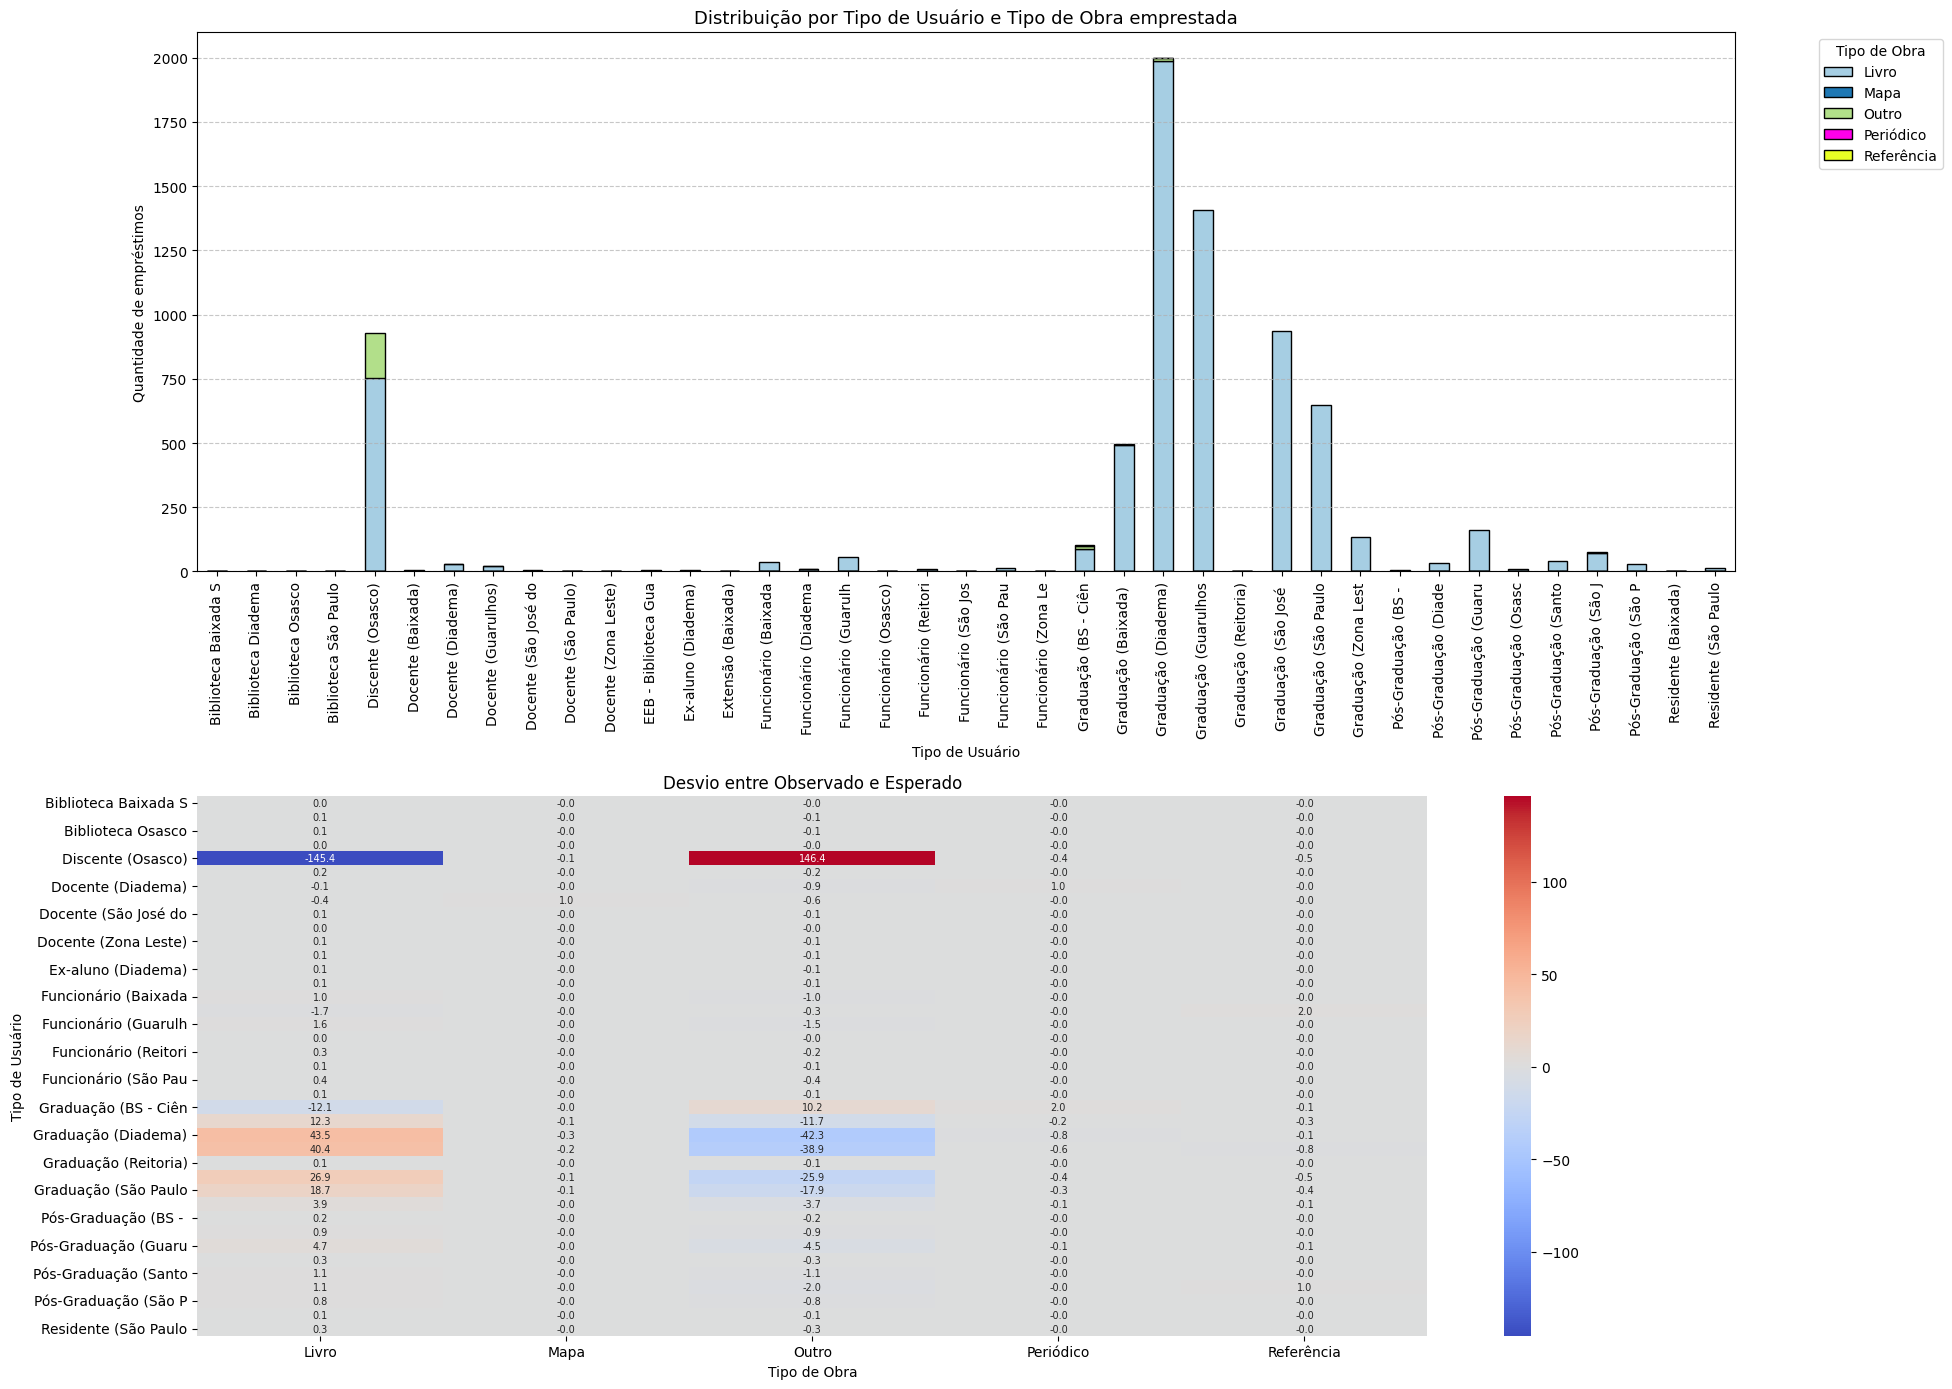

In [49]:
# Chi
tabela = pd.crosstab(df['DESC_CATEG_USUARIO'], df['Nome tipo obra'])

chi2, p, dof, expected = chi2_contingency(tabela)

# Diferença entre observado e esperado
expected = pd.DataFrame(expected, index=tabela.index, columns=tabela.columns)
diff = tabela - expected

fig, axes = plt.subplots(2, 1, figsize=(20, 14)) 

# Gráfico 1: barras empilhadas
cores = ['#a6cee3', '#1f78b4', '#b2df8a', "#ff00ea", "#e9ff25"] 
tabela.plot(kind='bar', stacked=True, color=cores, ax=axes[0], edgecolor='black')
axes[0].set_title('Distribuição por Tipo de Usuário e Tipo de Obra emprestada', fontsize=13)
axes[0].set_xlabel('Tipo de Usuário')
axes[0].set_ylabel('Quantidade de empréstimos')
axes[0].legend(title='Tipo de Obra', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].tick_params(axis='x', rotation=90)

# Gráfico 2: mapa de calor da diferença (observado - esperado)
sns.heatmap(diff, annot=True, fmt=".1f", cmap="coolwarm", center=0, ax=axes[1], annot_kws={"size": 7})
axes[1].set_title('Desvio entre Observado e Esperado')
axes[1].set_xlabel('Tipo de Obra')
axes[1].set_ylabel('Tipo de Usuário')

plt.tight_layout()
plt.subplots_adjust(right=0.87)
plt.show()

In [50]:
df['data_emprestimo'] = pd.to_datetime(df['DATA_EMPRESTIMO_CHAR'], errors='coerce', dayfirst=True)
df['data_devolucao'] = pd.to_datetime(df['DATA_DEV_EFETIVA_CHAR'], errors='coerce', dayfirst=True)

df['dias_emprestados'] = (df['data_devolucao'] - df['data_emprestimo']).dt.days

df = df[df['dias_emprestados'].notnull() & (df['dias_emprestados'] >= 0)]

df_grouped = df.groupby(['dias_emprestados']).size().reset_index(name='qtd_emprestimos')

Estatística W: 0.5011
p-valor: 0.0
Resultado: Os dados NÃO seguem uma distribuição normal (rejeta H₀)


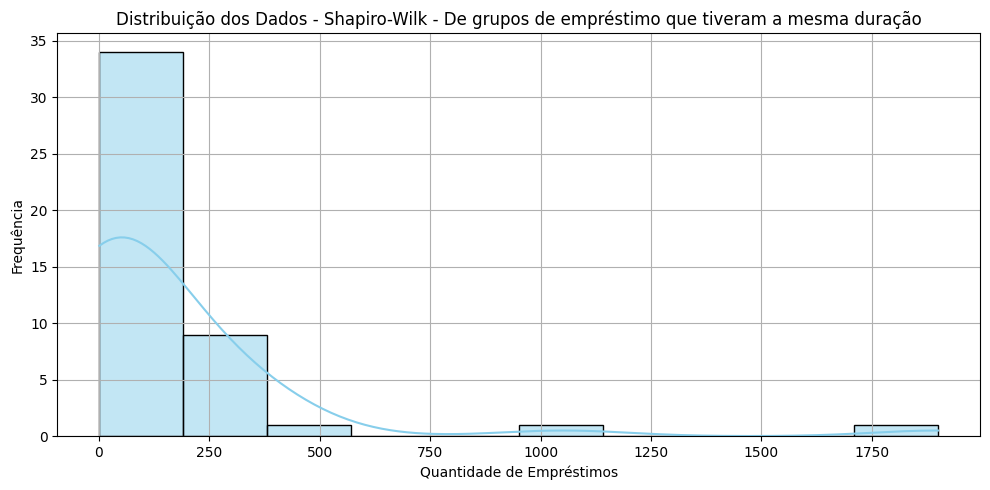

In [51]:
# Shapiro-Wilk
from scipy.stats import shapiro

stat, p = shapiro(df_grouped['qtd_emprestimos'].values)

print("Estatística W:", round(stat, 4))
print("p-valor:", round(p, 4))
if p < 0.05:
    print("Resultado: Os dados NÃO seguem uma distribuição normal (rejeta H₀)")
else:
    print("Resultado: Os dados seguem uma distribuição normal (não rejeita H₀)")

plt.figure(figsize=(10, 5))
sns.histplot(df_grouped['qtd_emprestimos'].values, kde=True, bins=10, color='skyblue')
plt.title("Distribuição dos Dados - Shapiro-Wilk - De grupos de empréstimo que tiveram a mesma duração")
plt.xlabel("Quantidade de Empréstimos")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()

Estatística D: 0.3124
p-valor: 0.0002
Resultado: Os dados NÃO seguem a distribuição normal (rejeta H₀)


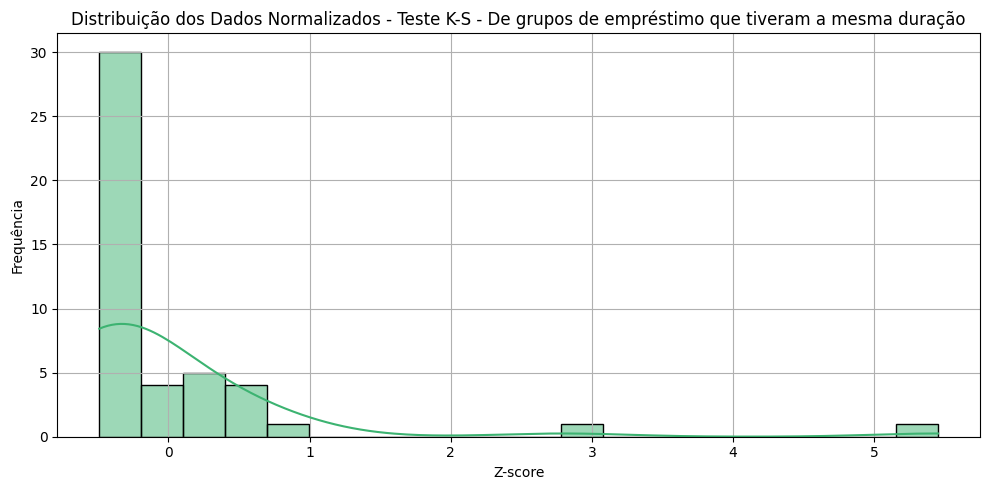

In [52]:
# Teste Kolmogorov-Smirnov (K-S)
from scipy.stats import kstest, norm

dados_norm = (df_grouped['qtd_emprestimos'].values - np.mean(df_grouped['qtd_emprestimos'].values)) / np.std(df_grouped['qtd_emprestimos'].values)

stat, p = kstest(dados_norm, 'norm')

print("Estatística D:", round(stat, 4))
print("p-valor:", round(p, 4))
if p < 0.05:
    print("Resultado: Os dados NÃO seguem a distribuição normal (rejeta H₀)")
else:
    print("Resultado: Os dados seguem a distribuição normal (não rejeita H₀)")

plt.figure(figsize=(10, 5))
sns.histplot(dados_norm, kde=True, color='mediumseagreen', bins=20)
plt.title("Distribuição dos Dados Normalizados - Teste K-S - De grupos de empréstimo que tiveram a mesma duração")
plt.xlabel("Z-score")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()

Estatística A²: 7.0355

Valores críticos e significância:
  15.0% : 0.5360
  10.0% : 0.6100
  5.0% : 0.7320
  2.5% : 0.8540
  1.0% : 1.0160

Resultado: Os dados NÃO seguem uma distribuição normal (rejeta H₀)


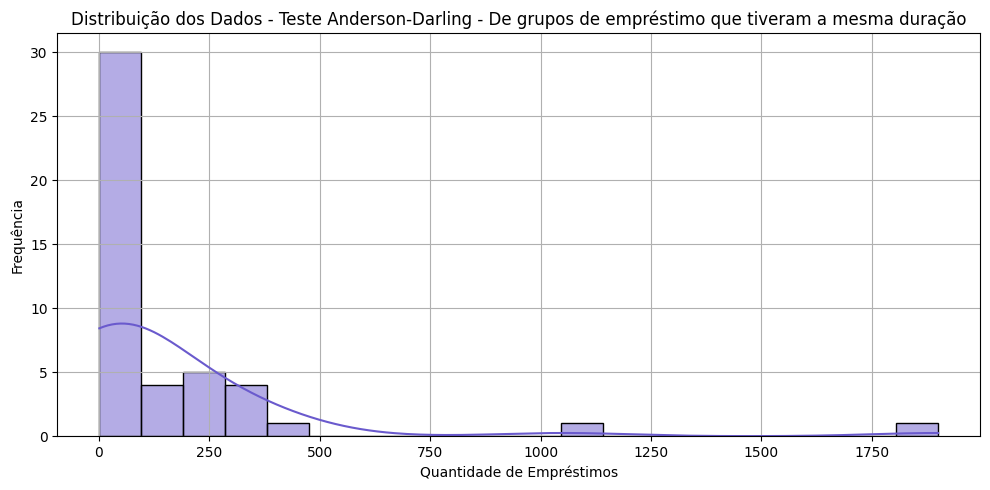

In [53]:
# Teste Anderson-Darling
from scipy.stats import anderson

resultado = anderson(df_grouped['qtd_emprestimos'].values, dist='norm')

print("Estatística A²:", round(resultado.statistic, 4))
print("\nValores críticos e significância:")
for critico, sig in zip(resultado.critical_values, resultado.significance_level):
    print(f"  {sig}% : {critico:.4f}")

# Veredito com base no nível de 5%
nivel_significancia = 5
indice = resultado.significance_level.tolist().index(nivel_significancia)
if resultado.statistic > resultado.critical_values[indice]:
    print("\nResultado: Os dados NÃO seguem uma distribuição normal (rejeta H₀)")
else:
    print("\nResultado: Os dados seguem uma distribuição normal (não rejeita H₀)")

plt.figure(figsize=(10, 5))
sns.histplot(df_grouped['qtd_emprestimos'].values, kde=True, color='slateblue', bins=20)
plt.title("Distribuição dos Dados - Teste Anderson-Darling - De grupos de empréstimo que tiveram a mesma duração")
plt.xlabel("Quantidade de Empréstimos")
plt.ylabel("Frequência")
plt.grid(True)
plt.tight_layout()
plt.show()